## Configurando o ambiente

In [32]:
!pyenv exec pip install numpy pandas matplotlib seaborn scikit-learn tensorflow kaggle


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


## Importando libs

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import os
import zipfile

## Baixando o dataset

In [34]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

with zipfile.ZipFile("daily-climate-time-series-data.zip", 'r') as zip_ref:
    zip_ref.extractall("data")


Dataset URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
License(s): CC0-1.0
daily-climate-time-series-data.zip: Skipping, found more recently modified local copy (use --force to force download)


## Carregando e explorando o dataset

In [35]:
data = pd.read_csv('data/DailyDelhiClimateTrain.csv')

In [36]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [37]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


## Pré-processamento dos dados

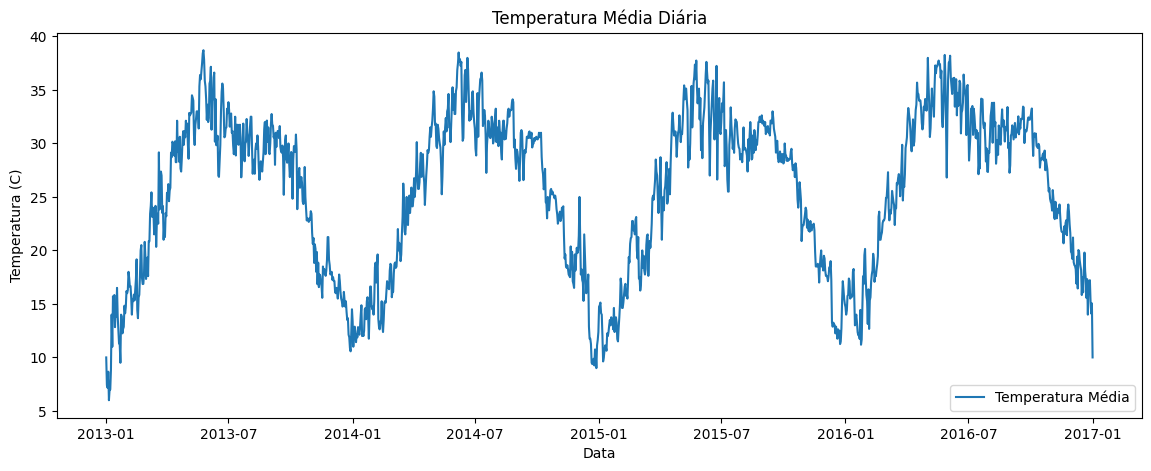

In [38]:
data['date'] = pd.to_datetime(data['date'])

data.set_index('date', inplace=True)

plt.figure(figsize=(14, 5))
plt.plot(data['meantemp'], label='Temperatura Média')
plt.title('Temperatura Média Diária')
plt.xlabel('Data')
plt.ylabel('Temperatura (C)')
plt.legend()
plt.show()

## Normalizando os dados

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['meantemp'].values.reshape(-1, 1))

train_size = int(len(data_scaled) * 0.80)
train, test = data_scaled[0:train_size], data_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Montando e treinando a RNN

In [40]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/20


/home/caze/.pyenv/versions/3.12.4/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1454 - val_loss: 0.0063
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - val_loss: 0.0061
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 0.0043

## Avaliando a RNN

In [41]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

train_score = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE: 2.23
Test RMSE: 2.10


## Visualizando as métricas

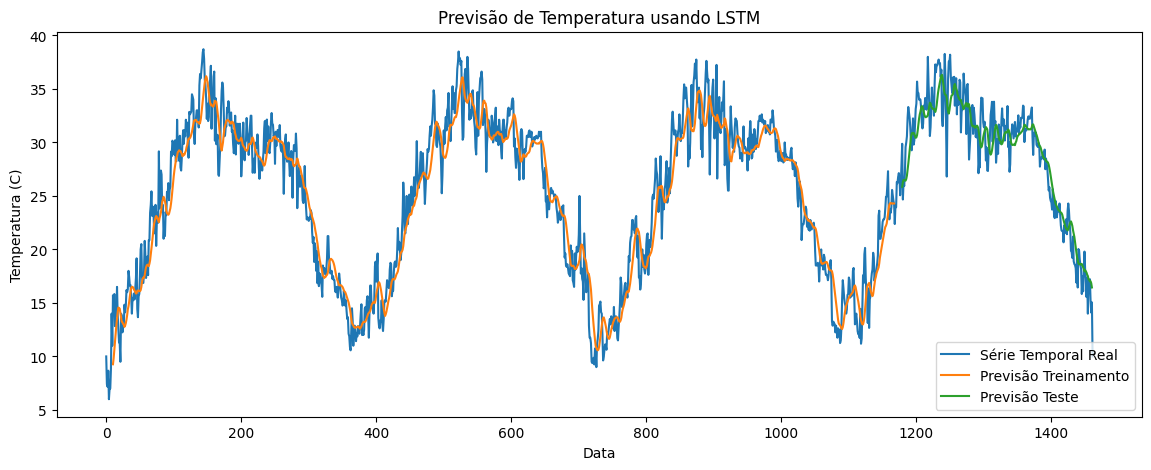

In [42]:
train_predict_plot = np.empty_like(data_scaled)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

test_predict_plot = np.empty_like(data_scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(data_scaled)-1, :] = test_predict

plt.figure(figsize=(14, 5))
plt.plot(scaler.inverse_transform(data_scaled), label='Série Temporal Real')
plt.plot(train_predict_plot, label='Previsão Treinamento')
plt.plot(test_predict_plot, label='Previsão Teste')
plt.title('Previsão de Temperatura usando LSTM')
plt.xlabel('Data')
plt.ylabel('Temperatura (C)')
plt.legend()
plt.show()